# Введение библиотек, обозначение пути, загрузка данных

In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
pd.options.display.max_rows = 999
pd.set_option("expand_frame_repr", True)

RAW_DATA_DIR = 'C:/Users/Admin/Desktop'
orders = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_1_orders.csv"))
products = pd.read_csv(os.path.join(RAW_DATA_DIR, "sbermarket_tab_2_4/tab_2_products_2020-06-19.csv"))
relative_discount = products["discount"] / (products["discount"] + products["price"])
product_properties = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_5_product_properties.csv"))

# Удаление простого мусора и проверка

## Продукты

In [2]:
products["brand_name"] = products["brand_name"].replace(["Без бренда",'-','No brand'], np.nan)
products = products.dropna(subset=['price', 'discount', 'quantity', 'product_name'])
products = products[products['price']>0]
products = products[products['quantity']>0]
products = products[products['discount']>=0]
# проверка
[products.isna().sum(),
len(products[products["price"] <= 0]),
len(products[products["quantity"] <= 0]),
len(products[products["discount"] < 0])]

[user_id                    0
 order_id                   0
 line_item_id               0
 price                      0
 quantity                   0
 discount                   0
 product_name               0
 product_id                 0
 brand_name            391088
 master_category_id       594
 parent_category_id         0
 dtype: int64,
 0,
 0,
 0]

## Свойства продуктов

In [3]:
product_properties.isna().sum(axis=0)

product_id        0
property_name     0
property_value    1
dtype: int64

In [4]:
product_properties[product_properties['property_value'].isna()]

,product_id,property_name,property_value
644240,84195,ingredients,NaN


In [5]:
# состав не может быть пустым
product_properties = product_properties.dropna(subset=['property_value'])

# Заказы

In [6]:
orders["platform"] = orders["platform"].replace("undefined", np.nan)
orders.isna().sum(axis=0)

user_id                   0
order_id                  0
order_created_time        0
retailer                  0
store_id                  0
platform              76536
dtype: int64

## Удаление пробелов в названиях

In [7]:
def ohne_probel(bn):
    try:
        b = bn.split()
        b = ' '.join(b)
        return b
    except AttributeError:
        return np.nan

In [8]:
products['brand_name']=products['brand_name'].apply(ohne_probel)
products['product_name']=products['product_name'].apply(ohne_probel)
product_properties['property_name']=product_properties['property_name'].apply(ohne_probel)
product_properties['property_value']=product_properties['property_value'].apply(ohne_probel)
orders['retailer']=orders['retailer'].apply(ohne_probel)

# Очистка пользователей B2B

In [9]:
sumprice = (products['quantity']*products['price']).rename("sumprice") # полная стоимость товара
products.insert(5, "Sumprice", sumprice, True)

## Найдем общую стоимость каждого заказа

In [10]:
sum_order = products.groupby(['user_id',"order_id"])["Sumprice"].sum().rename("sum_order")

<AxesSubplot:>

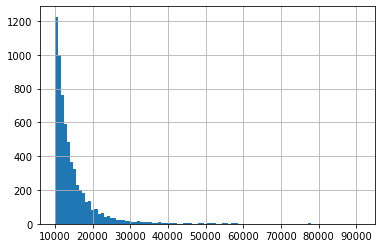

In [11]:
sum_order[(100000>sum_order)&(10000<sum_order)].hist(bins =100)

Видно, что это почти непрерывная экспонента, правильнее всего оборвать тогда, когда заканчивается непрерывность.

<AxesSubplot:>

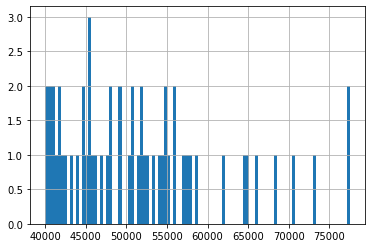

In [12]:
sum_order[(80000>sum_order)&(40000<sum_order) ].hist(bins =100)

Возьму ограничение в 60к на общую стоимость заказа

In [13]:
delete = sum_order[(60000<sum_order)].index.get_level_values('user_id')
delete

Int64Index([  40495,   56037,  169609,  171391,  734560, 1118259, 1196026,
            1238487, 1326001, 1429992, 1577515, 1711813, 1790187, 1823770,
            2213288, 2226519],
           dtype='int64', name='user_id')

In [14]:
products = products[~products["user_id"].isin(delete)].sort_values('Sumprice')

# Фильтры
Но все равно некоторые товары очевидно куплены не для личного пользования - 100 пачек кофе, например

Посмотрев на график зависимости количества одинаковых товаров от их суммарной стоимости, я пришел к выводу использования 4 фильтров:

1) 1 или 2 товара могут быть любой стоимости

2) Суммарная стоимость любого количества товаров не больше 1000

3) почти все продукты находятся под прямой (количество)/40 + (суммарная цена)/10000 = 1

4) питьевые жидкости и кормы для животных под прямой (количество)/80 + (суммарная цена)/15000) = 1

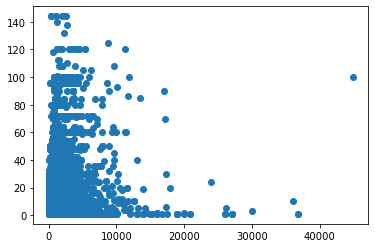

In [15]:
#на графике не указаны точки с количеством больше 150, для наглядности
# до применения фильтров:
prod = products[(products['quantity']<150)]
plt.scatter(prod['Sumprice'], prod['quantity'])

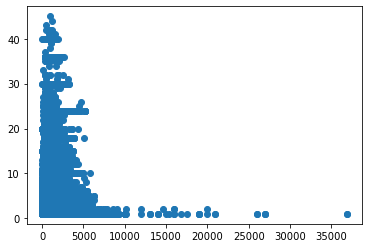

In [16]:
# после применения фильтров:
pr = products[(products['quantity'] <= 2) | ((products['Sumprice']<140) | (products['quantity']/30 + products['Sumprice']/7500 <1) | (((products['parent_category_id']==345)|(products['parent_category_id']==74))&((products['quantity']/50+products['Sumprice']/10000)<1)))]
plt.scatter(pr['Sumprice'], pr['quantity'])
#на графике не указаны точки с количеством больше 45, для наглядности

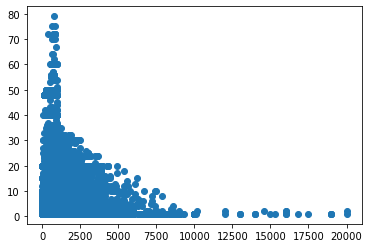

In [17]:
# так выглядят очищенные данные
delete1 = products[(products['quantity'] > 2) & (products['Sumprice']>1000) & ((products['quantity']/40 + products['Sumprice']/10000 > 1) | (((products['parent_category_id']==345)|(products['parent_category_id']==74))&((products['quantity']/80+products['Sumprice']/15000)>1)))]
produ =products[(~products["user_id"].isin(delete1['user_id'].values))&(products['quantity']<80)&(products['Sumprice']<20000)]
plt.scatter(produ['Sumprice'], produ['quantity'])

In [29]:
# очистка
products = produ
products

,user_id,order_id,line_item_id,price,quantity,Sumprice,discount,product_name,product_id,brand_name,master_category_id,parent_category_id
708980,992631,11307025,120837533,0.04,1,0.04,0.0,Пирог Лента с клубникой ~500 г,7014941,Лента,598.0,51
1826714,1809434,11931033,122364502,0.04,1,0.04,0.0,Пирог Лента с клубникой ~500 г,7014941,Лента,598.0,51
2450097,2150633,12009437,118524116,0.04,2,0.08,0.0,Пирог Лента с клубникой ~500 г,7014941,Лента,598.0,51
2690829,2211929,11814354,120383237,0.04,3,0.12,0.0,Пирог Лента с клубникой ~500 г,7014941,Лента,598.0,51
1079174,1320563,12349872,120028450,0.28,1,0.28,0.0,"Колбаса Дым Дымыч Со Сливками вареная ~1,2 кг",6827179,Дым Дымычъ,43.0,42
...,...,...,...,...,...,...,...,...,...,...,...,...
2084622,1950342,12630135,123661511,18999.00,1,18999.00,0.0,Кресло руководителя Самурай черное,5470642,NaN,706.0,487
152237,209259,10521153,121735833,18999.00,1,18999.00,0.0,Качели садовые Green apple Рандеву Премиум,7072074,Green Apple,930.0,543
2684185,2210610,12382067,120282018,18999.00,1,18999.00,0.0,Качели садовые Green apple Рандеву Премиум,7072074,Green Apple,930.0,543
2715311,2216288,7533759,49656982,9999.00,2,19998.00,2000.0,Гриль-тележка Tarrington House угольный со сто...,5474198,Tarrington House,431.0,429


## Найдем потраченные деньги каждым пользователем

In [19]:
sum_user = products.groupby(["user_id"])["Sumprice"].sum().rename("sum_user")

<AxesSubplot:>

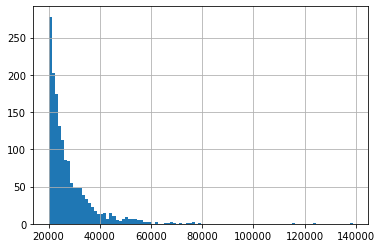

In [20]:
sum_user[(200000>sum_user)&(20000<sum_user) ].hist(bins =100)

Видно, что это почти непрерывная экспонента

<AxesSubplot:>

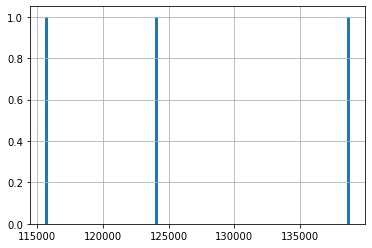

In [21]:
sum_user[(100000<sum_user) ].hist(bins =100)

обрежу на 200к

In [22]:
products = products[~products["user_id"].isin(sum_user[(200000<sum_user) ].index)]

# Черновик

In [23]:
products = products[products['line_item_id']!= 123437791] #артефакт


In [24]:
products.groupby('user_id')["price"]